In [1]:
import torch.nn as nn
from collections import OrderedDict


class CoderNetwork(nn.Module):
    r"""Encoder/Decoder for use in VAE based on Kingma and Welling
    
    Args:
        input_dim: input dimension (int)
        output_dim: output dimension (int)
        hidden_dim: hidden layer dimension (int)
        coder_type: encoder/decoder type can be 
                   'Gaussian'   - Gaussian with diagonal covariance structure
                   'I-Gaussian' - Gaussian with identity as covariance matrix 
                   'Bernoulli'  - Bernoulli distribution       
    """
    
    def __init__(self, input_dim, hidden_dim, output_dim, coder_type='Gaussian'):
        super().__init__()
        
        assert coder_type in  ['Gaussian', 'I-Gaussian' ,'Bernoulli'], \
            'unknown coder_type'
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.coder_type = coder_type
        
        self.coder = nn.Sequential(OrderedDict([
            ('h', nn.Linear(input_dim, hidden_dim)),
            ('ReLU', nn.ReLU()) # ReLU instead of Tanh proposed by K. and W.       
        ]))
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        
        if coder_type == 'Gaussian':
            self.fc_log_var = nn.Linear(hidden_dim, output_dim)
        elif coder_type == 'Bernoulli':
            self.sigmoid_mu = nn.Sigmoid()
        return
    
    def forward(self, inp):
        out = self.coder(inp)
        mu = self.fc_mu(out)
        
        if self.coder_type == 'Gaussian':
            log_var = self.fc_log_var(out)
            return [mu, log_var]
        elif self.coder_type == 'I-Gaussian':
            return mu
        elif self.coder_type == 'Bernoulli':
            return self.sigmoid_mu(mu)
        return

In [2]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal


class VAE(nn.Module):
    r"""A simple VAE class based on Kingma and Welling
        
    Args:
        encoder_network:  instance of CoderNetwork class
        decoder_network:  instance of CoderNetwork class
        L:                number of samples used during reparameterization trick
    """
    
    def __init__(self, encoder_network, decoder_network, L=1):
        super().__init__()
        self.encoder = encoder_network
        self.decoder = decoder_network
        self.L = L
        
        latent_dim = encoder_network.output_dim
                
        self.normal_dist = MultivariateNormal(torch.zeros(latent_dim), 
                                              torch.eye(latent_dim))
        return
    
    def forward(self, x):
        L = self.L
        
        z, mu_E, log_var_E = self.encode(x, L)
        # regularization term per batch, i.e., size: (batch_size)
        regularization_term = (1/2) * (1 + log_var_E - mu_E**2
                                       - torch.exp(log_var_E)).sum(axis=1)
        
        # upsample x and reshape
        batch_size = x.shape[0]
        x_ups = x.repeat(L, 1).view(batch_size, L, -1)    
        if self.decoder.coder_type == 'Gaussian':
            # mu_D, log_var_D have shape (batch_size, L, output_dim)
            mu_D, log_var_D = self.decode(z)
            # reconstruction accuracy per batch, i.e., size: (batch_size)
            recons_acc = (1/L) * (-(0.5)*(log_var_D.sum(axis=2)).sum(axis=1)
               -(0.5) * ((1/torch.exp(log_var_D))*((x_ups - mu_D)**2)
                         ).sum(axis=2).sum(axis=1))
        elif self.decoder.coder_type == 'I-Gaussian':
            # mu_D has shape (batch_size, L, output_dim)
            mu_D = self.decode(z)
            # reconstruction accuracy per batch, i.e., size: (batch_size)
            recons_acc = (1/L) * (-(0.5) * ((x_ups - mu_D)**2
                                            ).sum(axis=2).sum(axis=1))
        elif self.decoder.coder_type == 'Bernoulli':
            # mu_D has shape (batch_size, L, output_dim)
            mu_D = self.decode(z)     
            # reconstruction accuracy per batch, i.e., size: (batch_size)
            # corresponds to the negative binary cross entropy loss (BCELoss)
            recons_acc = (1/L) * (x_ups * torch.log(mu_D) + 
                                  (1 - x_ups) * torch.log(1 - mu_D)
                                  ).sum(axis=2).sum(axis=1)
        loss = - regularization_term.sum() - recons_acc.sum()
        return loss
    
    def encode(self, x, L=1):
        # get encoder distribution parameters
        mu_E, log_var_E = self.encoder(x)
        # sample noise variable L times for each batch
        batch_size = x.shape[0]
        epsilon = self.normal_dist.sample(sample_shape=(batch_size, L, ))
        # upsample mu_E, log_var_E and reshape
        mu_E_ups = mu_E.repeat(L, 1).view(batch_size, L, -1) 
        log_var_E_ups = log_var_E.repeat(L, 1).view(batch_size, L, -1)
        # get latent variable by reparametrization trick
        z = mu_E_ups + torch.sqrt(torch.exp(log_var_E_ups)) * epsilon
        return z, mu_E, log_var_E
    
    def decode(self, z):
        # get decoder distribution parameters
        if self.decoder.coder_type == 'Gaussian':
            mu_D, log_var_D = self.decoder(z)
            return mu_D, log_var_D
        elif self.decoder.coder_type == 'I-Gaussian':
            mu_D = self.decoder(z)
            return mu_D
        elif self.decoder.coder_type == 'Bernoulli':
            mu_D = self.decoder(z)
            return mu_D
        return

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def train(decoder_type, dataset, x_dim, hid_dim, z_dim, batch_size, L, epochs):
    encoder_network = CoderNetwork(input_dim=x_dim, 
                                   hidden_dim=hid_dim, 
                                   output_dim=z_dim,
                                   coder_type='Gaussian')
    decoder_network = CoderNetwork(input_dim=z_dim, 
                                   hidden_dim=hid_dim, 
                                   output_dim=x_dim,
                                   coder_type=decoder_type)
    
    model = VAE(encoder_network, decoder_network, L=L)
    data_loader = DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    print('Start training with {} decoder distribution\n'.format(decoder_type))
    for epoch in range(1, epochs + 1):
        print('Epoch {}/{}'.format(epoch, epochs))
        avg_loss = 0
        for counter, (mini_batch_data, label) in enumerate(data_loader):
            
            model.zero_grad()
            
            loss = model(mini_batch_data.view(-1, x_dim))
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item() / len(dataset)
            
            if counter % 20 == 0 or (counter + 1)==len(data_loader):
                batch_loss = loss.item() / len(mini_batch_data)
                print('\r[{}/{}] batch loss: {:.2f}'.format(counter + 1,
                                                            len(data_loader),
                                                            batch_loss),
                      end='', flush=True)
        print('\nAverage loss: {:.3f}'.format(avg_loss)) 
    print('Done!\n')
    trained_VAE = model
    return trained_VAE

dataset = datasets.MNIST('data/', transform=transforms.ToTensor(), download=True)
x_dim, hid_dim, z_dim = 28*28, 400, 20
batch_size, L, epochs = 128, 5, 3

Bernoulli_VAE = train('Bernoulli', dataset, x_dim, hid_dim, z_dim, 
                      batch_size, L, epochs)
Gaussian_VAE = train('Gaussian', dataset, x_dim, hid_dim, z_dim, 
                     batch_size, L, epochs)
I_Gaussian_VAE = train('I-Gaussian', dataset, x_dim, hid_dim, z_dim, 
                       batch_size, L, epochs)

Start training with Bernoulli decoder distribution

Epoch 1/3
[469/469] batch loss: 136.42
Average loss: 149.433
Epoch 2/3
[469/469] batch loss: 115.42
Average loss: 124.348
Epoch 3/3
[469/469] batch loss: 121.92
Average loss: 120.033
Done!

Start training with Gaussian decoder distribution

Epoch 1/3
[469/469] batch loss: -1127.34
Average loss: -1181.368
Epoch 2/3
[469/469] batch loss: -1405.31
Average loss: -1304.236
Epoch 3/3
[469/469] batch loss: -1470.01
Average loss: -1288.095
Done!

Start training with I-Gaussian decoder distribution

Epoch 1/3
[469/469] batch loss: 22.56
Average loss: 28.216
Epoch 2/3
[469/469] batch loss: 21.52
Average loss: 22.294
Epoch 3/3
[469/469] batch loss: 21.14
Average loss: 21.600
Done!



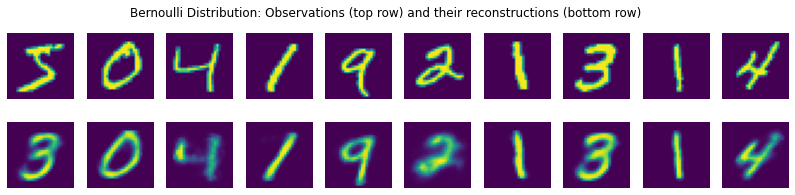

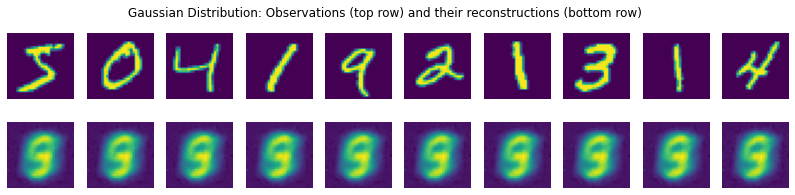

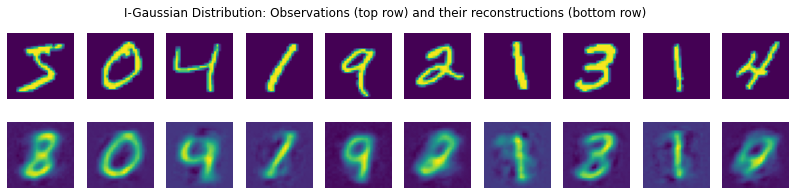

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_results(trained_model, dataset, n_samples):
    decoder_type = trained_model.decoder.coder_type
    
    fig = plt.figure(figsize=(14, 3))
    fig.suptitle(decoder_type + ' Distribution: Observations (top row) and ' +
                 'their reconstructions (bottom row)')
    for i_sample in range(n_samples):
        x_sample = dataset[i_sample][0].view(-1, 28*28)
        
        z, mu_E, log_var_E = trained_model.encode(x_sample, L=1)
        if decoder_type in ['Bernoulli', 'I-Gaussian']:
            x_prime = trained_model.decode(z)
        else:
            x_prime = trained_model.decode(z)[0]
    
        plt.subplot(2, n_samples, i_sample + 1)
        plt.imshow(x_sample.view(28, 28).data.numpy())
        plt.axis('off')
        plt.subplot(2, n_samples, i_sample + 1 + n_samples)
        plt.imshow(x_prime.view(28, 28).data.numpy())
        plt.axis('off')
    return


n_samples = 10
plot_results(Bernoulli_VAE, dataset, n_samples)
plot_results(Gaussian_VAE, dataset, n_samples)
plot_results(I_Gaussian_VAE, dataset, n_samples)